In this script the standard one class classification models are compared with the Deep One Class Model

# Import the datasets

In [1]:
# Import the libraries and codes
import pandas as pd
import warnings
import sys
warnings.simplefilter("ignore", UserWarning)
paths = ['../models/python_codes/', '../models/standard_models/']
sys.path.extend(paths)
from classifiers import classifiers
from GMM_classifier import GMM
from build_ensemble import Ensemble
from learning_curve_adjusted import *
from cross_validate import cross_val


In [2]:
# Import the labeled dataset after the feature engineering for evaluating the standard one class algorithms
df= pd.read_pickle('../data/df_reduced.pkl')
df=df.fillna(0)
df.head()

,Identifier,nBM,nHet,ZM1V,DBI,MAXDN,MAXDP,DELS,CIC0,J_D/Dt,...,SpMax3_Bh(s),SpMax7_Bh(s),P_VSA_v_2,P_VSA_s_6,Eta_F_A,Eig02_AEA(dm),Eig03_AEA(dm),Eig04_AEA(dm),nHAcc,Uc
0,WOVMEB,0.034483,0.000000,0.018611,0.073325,0.027142,0.008182,0.001948,0.280067,0.039639,...,0.321908,0.493806,0.000000,0.000000,0.449448,0.498103,0.607893,0.667916,0.000000,0.796001
1,PIWKEL,0.057471,0.088889,0.116679,0.146649,0.184005,0.368062,0.063556,0.321768,0.186531,...,0.062123,0.099236,0.000000,0.000000,0.279807,0.709408,0.604336,0.668781,0.000000,0.268420
2,OTIHIJ,0.195402,0.044444,0.147459,0.302317,0.110113,0.024137,0.020041,0.600334,0.104237,...,0.090555,0.005535,0.000000,0.000000,0.408383,0.007018,0.169377,0.010378,0.000000,0.376728
3,DABLOJ,0.005747,0.044444,0.027201,0.163954,0.170389,0.192418,0.012151,0.154962,0.000000,...,0.695813,0.498814,0.326708,0.211564,0.615973,0.644917,0.659383,0.715624,0.131579,0.607167
4,PIGJUK,0.074713,0.088889,0.110952,0.179572,0.027324,0.022024,0.007123,0.349291,0.169320,...,0.695813,0.443068,0.318692,0.211564,0.558482,0.623293,0.655318,0.712165,0.105263,0.464233


## Calculate the learing curves for the standard models

In [16]:
class GMM(GaussianMixture):
  def __init__(self, n_components, covariance_type, random_state):
    super().__init__(n_components=n_components , covariance_type=covariance_type, random_state=random_state)

  def fit(self, X, y):
    super().fit(X, y)
    self.prob = super().score_samples(X)
    self.c = percentile(self.prob, 100 * contamination)

  def predict(self, X):
    scores = []
    proba=super().score_samples(X)
    
    scores =(proba <= self.c).astype('int').ravel()

    return scores

In [56]:
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 4, covariance_type='spherical', random_state=0), 
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=16, alpha=0.7), 
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=8), contamination=0.05),
        'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=7), 
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
    'CBLOF':    CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
 }

In [73]:
#hyperopt
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 4, covariance_type='spherical', random_state=0), 
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 15, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':  HBOS(contamination=0.05, n_bins=15, alpha=0.7), 
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=8), contamination=0.05,  random_state=0),
        'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000, random_state=0),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=7), 
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05), 
    'CBLOF':  CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=10) #10  CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12,  random_state=0)
 }

In [57]:
# Calculate the learning curves of the Ensemble
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
# The training set becomes an input to the classifiers in a bidirectional way, to ensure that in each 
# fold the training is order invariant

X_train=df.iloc[:1722, 1:]
shuffle(X_train)
y=np.zeros(X_train.shape[0])

clf  = Ensemble(classifiers) 

scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, 
                       random_state= 0, return_times=True)

train_sizes = train_sizes*2        
train_scores_mean_ens = np.mean(train_scores, axis=1)*100
train_scores_std_ens = np.std(train_scores, axis=1)*100
test_scores_mean_ens = np.mean(test_scores, axis=1)*100
test_scores_std_ens = np.std(test_scores, axis=1)*100

print(train_sizes)
print(test_scores_mean_ens)
test_scores_std_ens

[  54  196  338  480  622  764  906 1048 1190 1332 1474 1616 1758 1900
 2042 2184 2326 2468 2610 2754]
[77.42298618 68.77148635 68.01533536 73.53235592 78.9917425  82.53083923
 82.47152005 83.86501517 82.70424671 83.28631614 84.6818335  88.22059319
 93.08998989 93.08982137 93.03168183 93.20626896 92.16329626 93.72935625
 92.45365689 93.61375126]


array([15.31013545, 14.00540872, 13.86542702, 17.20957498, 18.87458841,
       15.4255184 , 14.79805721, 13.68650423, 14.91371573, 15.52204445,
       16.30218587, 10.78104091,  1.90210268,  2.13634783,  2.51677269,
        2.57167823,  4.69213978,  2.9604205 ,  5.10542541,  3.6117644 ])

In [128]:
# Calculate the learning curves of the Ensemble
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score

# The training set becomes an input to the classifiers in a bidirectional way, to ensure that in each 
# fold the training is order invariant

X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])
from sklearn.utils import shuffle
#shuffle(X_train)

clf  = Ensemble(classifiers) 

scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, 
                       random_state= 0, return_times=True)

train_sizes = train_sizes*2        
train_scores_mean_ens = np.mean(train_scores, axis=1)*100
train_scores_std_ens = np.std(train_scores, axis=1)*100
test_scores_mean_ens = np.mean(test_scores, axis=1)*100
test_scores_std_ens = np.std(test_scores, axis=1)*100

print(train_sizes)
print(test_scores_mean_ens)
test_scores_std_ens

[  54  196  338  480  622  764  906 1048 1190 1332 1474 1616 1758 1900
 2042 2184 2326 2468 2610 2754]
[77.19042804 68.30704415 68.36383552 74.1718908  79.22430064 81.02376138
 82.93461409 83.69076508 82.12403101 83.22817661 85.66784631 88.27822717
 93.08998989 92.68301314 92.97387934 92.85827435 91.98854061 93.67121672
 92.51196495 92.86080216]


array([15.05577083, 14.01273228, 13.89959692, 17.57970076, 19.0070724 ,
       17.43548716, 13.27784656, 13.59872304, 15.77578586, 15.59905754,
       14.42728959, 10.65563646,  1.97190544,  1.830374  ,  2.48483243,
        2.91900869,  4.44511596,  2.88424724,  5.33242335,  5.33544315])

In [58]:
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
std=[]

X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])
scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.05, 1.0, 20)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, random_state= 0,
                       return_times=True)        
  train_scores_mean = np.mean(train_scores, axis=1)*100
  train_scores_std = np.std(train_scores, axis=1)*100
  test_scores_mean = np.mean(test_scores, axis=1)*100
  test_scores_std = np.std(test_scores, axis=1)*100
  accuracy.append(test_scores_mean)
  std.append(test_scores_std)

In [59]:
accuracy

[array([71.67172228, 70.39366363, 73.29389956, 81.30805527, 83.28244018,
        86.70340411, 87.0520728 , 86.70390967, 86.82018874, 86.82136839,
        89.02763734, 92.04634311, 91.98618133, 91.40562858, 92.97489046,
        92.97489046, 93.67205932, 92.1619481 , 93.26541962, 93.32170543]),
 array([77.24553421, 66.61948096, 66.90916751, 76.14273677, 80.90630266,
        83.10751601, 83.80434783, 85.66481294, 85.20256151, 85.78294574,
        87.75530839, 92.62571621, 92.33400741, 92.15975733, 92.45028648,
        92.50859454, 93.20525784, 93.20475228, 93.26289181, 93.32119987]),
 array([74.22918773, 79.51769464, 73.29946073, 77.18705763, 77.06993596,
        79.91658241, 80.61375126, 79.97489046, 81.1380182 , 82.3008089 ,
        83.23036737, 85.49376475, 88.97421638, 89.32339063, 89.0338726 ,
        88.57077856, 88.97775531, 88.8033367 , 88.91961577, 89.0364004 ]),
 array([71.67458713, 73.06909336, 72.37495787, 80.27047523, 83.00286485,
        90.88725986, 89.66582406, 89.60802157

### Calculate k-fold cross validation for the standard models

In [74]:
import pandas as pd
import numpy as np
from sklearn import metrics

def cross_val(clf):
  valid =[]
  X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

  # Perform k-fold cross validation
  from sklearn.model_selection import KFold
  kf = KFold(n_splits = 5, random_state=0)
  kf.get_n_splits(X_train_val)
  for train, test in kf.split(X_train_val):
      train_data = np.array(X_train_val)[train]
      train_label = train_data[:,-1]
      test_data = np.array(X_train_val)[test]
      test_label = test_data[:, -1]
      train_data = np.vstack([train_data, np.hstack([train_data[:,24:], train_data[:,:24]])])
      train_label = np.concatenate([train_label, train_label])
      clf.fit(train_data[:, :-1],train_label )
      pred_train = clf.predict(train_data[:,:-1])
      pred_test = clf.predict(test_data[:,:-1])
      valid.append(metrics.accuracy_score(pred_test, test_label))
  return valid

In [75]:
from random import Random
from sklearn.model_selection import KFold
val_list = []
df=df.fillna(0)
X_train= df.iloc[:, 1:]
for i, (clf_name, clf) in enumerate(classifiers.items()):
  k = cross_val(clf)
  val_list.append(k)


In [76]:
#Calcualte the k-fold accuracy of the ensemble

clf_ens = Ensemble(classifiers)
ens_kfold = cross_val(clf_ens)

In [77]:
print(np.mean(val_list, 1))
print(np.std(val_list, 1))

[0.93234254 0.93030386 0.92277652 0.93437658 0.92392117 0.90881839
 0.9346639  0.93206028]
[0.00959554 0.01930667 0.04905902 0.00859878 0.02727008 0.01697165
 0.01078315 0.02877738]


In [78]:
print(np.mean(ens_kfold, 0))
print(np.std(ens_kfold, 0))


0.9410516589597326
0.015673751673561272


### Calculate the learning curve for the neural network

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
#from utils.visualization.plot_images_grid import plot_images_grid
import deepSVDD
from base.base_net import BaseNet


In [ ]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data = data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder =  nn.Sequential( nn.Linear(in_features=100, out_features=1857), nn.LeakyReLU(),
          nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):
  
  return PairsEncoder()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
dataset = Pairs_Dataset('', data=df.iloc[:, 1:])

In [ ]:
torch.manual_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn import metrics
scores1=[]

def Average(lst): 
    return sum(lst) / len(lst) 
def deep_one_test(trainer, dataset: Pairs_Dataset(''), net: BaseNet, threshold=None):
        logger = logging.getLogger()
        nu = 0.05
        # Set device for network
        device = 'cuda'
        net = net.to(trainer.device)        
        if threshold == None:
          threshold = get_R(trainer, dataset, net, nu)           
        
        #print('Thres:', threshold)
        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)

        # Testing
        logger.info('Starting testing...')
        #start_time = time.time()
        idx_label_score = []
        net.eval()
        
        all_scores=[]
        with torch.no_grad():
             
          for data in test_loader:
            inputs, labels, idx = data
                
                #labels = np.zeros(pd.DataFrame(labels).shape[0])
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            if trainer.objective == 'soft-boundary':
              scores = dist - trainer.R ** 2
            else:
             scores = dist.cpu().numpy()
             all_scores.append(scores)
        
        scores = np.concatenate(all_scores)
        scores = np.array(scores)
        scores = (scores > threshold ).astype(np.int)
        score = (scores == 0).sum()

        # Compute AUC
        labels = np.zeros_like(scores)
        trainer.test_auc = metrics.accuracy_score(labels, scores, normalize=True)
        logger.info('Test set accuracy: {:.2f}%'.format(100*trainer.test_auc))
        scores1  = (100*trainer.test_auc)
        logger.info('Finished testing.')
        return labels, scores, scores1, threshold

In [ ]:
from optim.ae_trainer import AETrainer
def pretrain(deepSVDD, dataset, optimizer_name: str = 'adam', lr: float = 1e-5, n_epochs: int = 50,
             lr_milestones: tuple = (), batch_size: int = 200, weight_decay: float = 1e-3, device: str = 'cuda',
             n_jobs_dataloader: int = 0):
    """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

    deepSVDD.ae_net = build_autoencoder(deepSVDD.net_name)
    deepSVDD.ae_optimizer_name = optimizer_name
    deepSVDD.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                batch_size=batch_size, weight_decay=weight_decay, device=device,
                                n_jobs_dataloader=n_jobs_dataloader)
    deepSVDD.ae_net = deepSVDD.ae_trainer.train(dataset, deepSVDD.ae_net)
    deepSVDD.init_network_weights_from_pretraining()

In [ ]:
def get_R(trainer, dataset, net, nu):
    net = net.to(trainer.device)
    train_loader, _ = dataset.loaders(batch_size=trainer.batch_size, num_workers=trainer.n_jobs_dataloader)
    
    all_scores = []
    with torch.no_grad():
        for data in train_loader:
            inputs, _, _ = data
            inputs = inputs.to(trainer.device)
            outputs = net(inputs)
            dist = torch.sum((outputs - trainer.c) ** 2, dim=1)
            all_scores.append(dist.cpu().numpy())
            
    scores = np.concatenate(all_scores)
    return np.percentile(scores, 100*(1-nu))

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

score_tot=[]

def test_net(train, test):
  dataset = Pairs_Dataset('', train, test, df.iloc[:, 1:])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 , 
                  lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)    
  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
               device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  return scores1


# Perform k-fold cross validation whilst increasing the amount of training data that are inputed to the model
X_train_val=pd.DataFrame(df.iloc[:, 1:].values)
Random(0).shuffle(X_train_val)
kf = KFold(n_splits = 5,  shuffle=False)
kf.get_n_splits(X_train_val)
scores2=[]

Random(0).shuffle(X_train_val)
kf = KFold(n_splits = 5,  shuffle=False)#, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]
set_seed()
n = np.linspace(.05, 1.0, 20)  
for train, test in kf.split(X_train_val):
  scores2=[]
  #Random(0).shuffle(train)
  for i in X_train_val.shape[0]* n:
    print('size:', i)    
    Random(0).shuffle(train)
    trainX = train[:int(i)]
    scores1 = test_net(trainX, test)
    scores2.append(scores1)
  score_tot.append(scores2)

In [ ]:
# Save the evaluation results for comparison with the standrard models
test_scores_mean = np.mean(score_tot, 0)
test_scores_std = np.std(score_tot,0)
deepsvdd_acc  = test_scores_mean 
deep_svdd_std = test_scores_std

In [26]:
deepsvdd_acc = np.array([81.1892484 , 91.75581395, 91.93023256, 93.03454668, 93.26373441,
       93.61223458, 93.03252444, 93.73003033, 93.43950118, 93.38136164,
       92.85776879, 93.32339063, 93.55443209, 93.84563532, 92.91691945,
       93.206606  , 93.09100101, 93.26457701, 93.67290192, 93.78682171])

deep_svdd_std = np.array([5.4950041 , 2.54900057, 2.27762141, 2.07305564, 1.56067457,
       1.61848493, 2.23861163, 1.49904053, 1.75640443, 1.35986527,
       0.72395944, 1.4406427 , 0.92755038, 1.18967304, 1.68116874,
       1.64591397, 1.15996663, 0.76434046, 1.77407158, 1.53061797])

### Calculate k-fold cross validation for the deep network

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from random import Random

# Perform k-fold cross validation
import random
X_train_val=pd.DataFrame(df.iloc[:1722, 1:].values)
kf_score=[]
kf = KFold(n_splits = 5,  shuffle=True, random_state=0)
kf.get_n_splits(X_train_val)
scores2=[]

for train, test in kf.split(X_train_val):
  dataset = Pairs_Dataset('', train, test)  
  Random(0).shuffle(train)
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60, 
                lr_milestones=(100,),
                 batch_size=200, 
                  weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)

  pred_train = deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60)#,
               lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

  pred_test, _, scores1, threshold = deep_one_test(deep_SVDD.trainer, dataset, deep_SVDD.net)
  scores2.append(scores1)
  score_mean = np.mean(scores2)
kf_score.append(scores2)
scores2

In [ ]:
# Print Deep Neural Network kfold Accuracy
print(np.mean(scores2, 0))
print(np.std(scores2, 0))
scores2

94.36737445230872
0.745873116098849


[93.6231884057971,
 94.4927536231884,
 93.6046511627907,
 95.63953488372093,
 94.47674418604652]

In [9]:
deep_kfold = [0.936231884057971, 0.944927536231884, 0.936046511627907,
 0.9563953488372093, 0.9447674418604652]

# Learning curves comparison

In [60]:
# Combine all the accuracy scores 
accuracy.append(test_scores_mean_ens)
accuracy.append(deepsvdd_acc)
std.append(test_scores_std_ens)
std.append(deep_svdd_std)

In [61]:
deepsvdd_acc = np.array([83.93964964, 93.17641003, 93.11848145, 93.32201202, 93.17691633,
       93.84438181, 93.7861579 , 94.28013299, 93.32184325, 93.43791136,
       93.61224559, 93.37964526, 93.55444358, 94.36700476, 93.32180106,
       93.55406386, 93.37994059, 93.78641104, 93.78657981, 93.87370473])


In [62]:
#accuracy = accuracy[:-1]

In [63]:
train_sizes =train_sizes*2
train_sizes 

array([ 136,  274,  412,  550,  688,  826,  962, 1100, 1238, 1376, 1514,
       1652, 1790, 1926, 2064, 2202, 2340, 2478, 2616, 2754])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


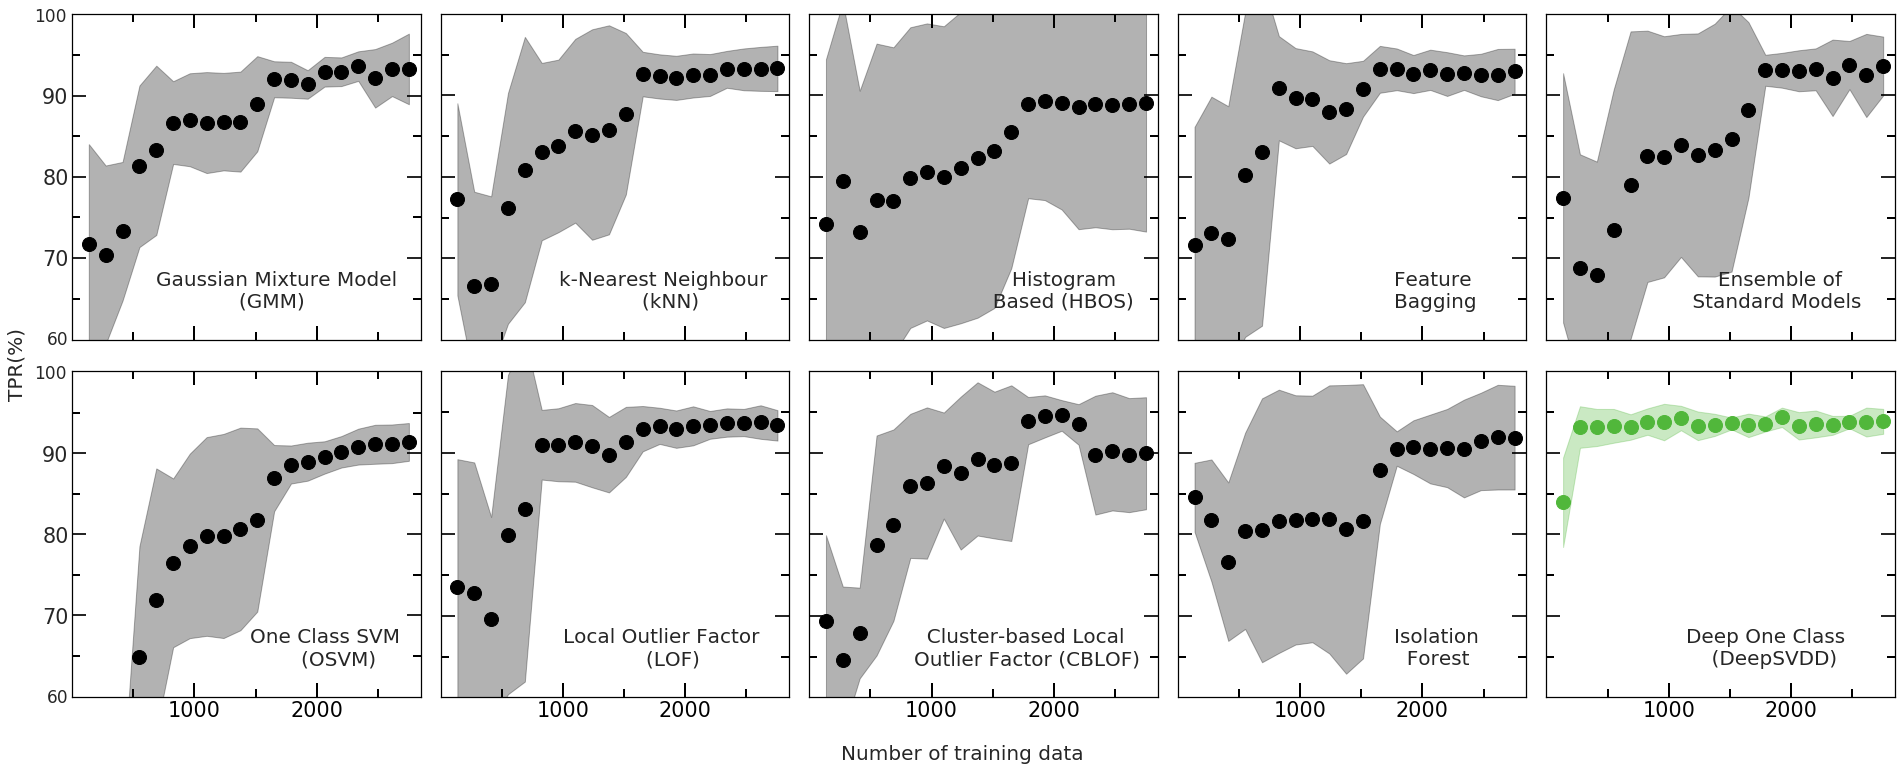

In [64]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt
#train_sizes =train_sizes*2
fig, axes = plt.subplots(figsize=(26,10),nrows=2, ncols=5,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

colors = ['red', 'tan']
ax0.plot(train_sizes,accuracy[0], 'o', color="black", markersize=14, label= 'Gaussiann Mixture Model (GMM)' )
ax0.fill_between(train_sizes,accuracy[0] - std[0],  accuracy[0] + std[0], alpha=0.3,  color="black")
ax0.set_ylim(59.9, 100.1)
ax0.set_xlim(130, 2850)
ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[-1].draw = lambda *args:None
#ax0.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax0.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax0.text(-0.0712, -0.015, '60', transform=ax0.transAxes, fontsize= 17)
ax0.text(-0.11, 0.978, '100', transform=ax0.transAxes, fontsize= 17)

# kNN
ax1.plot(train_sizes, accuracy[1], 'o', color="black", markersize=14, label= 'K Nearest Neighbors (KNN)' )
ax1.fill_between(train_sizes,accuracy[1] - std[1],  accuracy[1] + std[1], alpha=0.3,  color="black")
ax1.set_ylim(60, 100)
ax1.set_xlim(130, 2850)
ax1.text(0.34, 0.1, 'k-Nearest Neighbour\n             (kNN)', transform=ax1.transAxes,fontsize=20)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None

# HBOS 
ax2.plot(train_sizes, accuracy[2], 'o', color="black",markersize=14, label= 'Histogram-base Outlier Detection (HBOS)' )
ax2.fill_between(train_sizes, accuracy[2] - std[2],  accuracy[2] + std[2], alpha=0.3,  color="black")
ax2.set_ylim(60, 100)
#ax2.set_title('Histogram Based (HBOS)', fontsize=20, y=1.02)  #fontweight='bold', 
ax2.set_xlim(130, 2850)
ax2.text(0.49, 0.1, '     Histogram\n  Based (HBOS)', transform=ax2.transAxes,fontsize=20)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Feature Bagging
ax3.plot(train_sizes,accuracy[3], 'o', color="black", markersize=14, label= 'Feature Bagging' )
ax3.fill_between(train_sizes, accuracy[3] - std[3],  accuracy[3] + std[3], alpha=0.3,  color="black")
ax3.set_ylim(60, 100)
ax3.set_xlim(130, 2850)
ax3.text(0.62, 0.1, 'Feature\nBagging', transform=ax3.transAxes,fontsize=20)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['left'].set_color('black')
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Isolation Forest
ax8.plot(train_sizes,accuracy[4], 'o', color="black",markersize=14, label= 'Isolation Forest' )
ax8.fill_between(train_sizes,accuracy[4] - std[4],  accuracy[4] + std[4], alpha=0.3,  color="black")
ax8.set_ylim(60, 100)
ax8.set_xlim(130, 2850)
ax8.text(0.62, 0.1, 'Isolation\n  Forest', transform=ax8.transAxes,fontsize=20)
ax8.spines['bottom'].set_color('black')
ax8.spines['top'].set_color('black')
ax8.spines['right'].set_color('black')
ax8.spines['left'].set_color('black')
ax8.tick_params(axis = 'both', which='both', width=2)
ax8.tick_params(axis='x', colors='black')
ax8.tick_params(axis = 'both', which='major', length=14)
ax8.tick_params(axis = 'both', which='minor', length=8, color='black')
ax8.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax8.set_xticks(major_ticks_x)
ax8.set_xticks(minor_ticks_x, minor=True)
ax8.set_yticks(major_ticks_y)
ax8.set_yticks(minor_ticks_y, minor=True)
ax8.set_yticklabels([])
#ax8.set_xticklabels([])  #
ax8.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax8.yaxis.get_major_ticks()[0].draw = lambda *args:None

# OCSVM
ax5.plot(train_sizes, accuracy[5], 'o', color="black", markersize= 14, label= 'One class SVM (OCSVM)' )
ax5.fill_between(train_sizes, accuracy[5]- std[5],  accuracy[5] + std[5], alpha=0.3,  color="black")
ax5.set_ylim(59.9, 100.1)
ax5.set_xlim(130, 2850)
ax5.text(0.51, 0.1, 'One Class SVM\n        (OSVM)', transform=ax5.transAxes,fontsize=20)
ax5.spines['bottom'].set_color('black')
ax5.spines['top'].set_color('black')
ax5.spines['right'].set_color('black')
ax5.spines['left'].set_color('black')
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])
#ax5.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax5.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax5.yaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.text(-0.0712, -0.015, '60', transform=ax5.transAxes, fontsize= 17)
ax5.text(-0.11, 0.978, '100', transform=ax5.transAxes, fontsize= 17)

# LOF
ax6.plot(train_sizes, accuracy[6], 'o', color="black", markersize=14,label= 'Local Outlier Factor (LOF)' )
ax6.fill_between(train_sizes,accuracy[6] - std[6],  accuracy[6] + std[6], alpha=0.3,  color="black")
ax6.set_ylim(60, 100)
ax6.set_xlim(130, 2850)
ax6.text(0.35, 0.1, 'Local Outlier Factor\n             (LOF)', transform=ax6.transAxes,fontsize=20)
ax6.spines['bottom'].set_color('black')
ax6.spines['top'].set_color('black')
ax6.spines['right'].set_color('black')
ax6.spines['left'].set_color('black')
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.set_yticklabels([])
#ax6.set_xticklabels([])
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None

# CBLOF
ax7.plot(train_sizes, accuracy[7], 'o', color="black",markersize= 14, label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax7.fill_between(train_sizes,accuracy[7] - std[7], accuracy[7] + std[7], alpha=0.3,  color="black")
ax7.set_ylim(60, 100)
ax7.set_xlim(130, 2850)
ax7.text(0.3, 0.1, '  Cluster-based Local\nOutlier Factor (CBLOF)', transform=ax7.transAxes,fontsize=20)
ax7.spines['bottom'].set_color('black')
ax7.spines['top'].set_color('black')
ax7.spines['right'].set_color('black')
ax7.spines['left'].set_color('black')
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.set_yticklabels([])
#ax7.set_xticklabels([])
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None

# DeepSVDD
ax9.plot(train_sizes, accuracy[9], 'o', color="#51b73b",markersize =14, label= 'DeepSVDD')
ax9.fill_between(train_sizes, accuracy[9] - std[9],  accuracy[9] + std[9], alpha=0.3,  color='#51b73b')   #'#028f1e')
ax9.set_ylim(60, 100)
ax9.set_xlim(130, 2850)
ax9.text(0.4, 0.1, 'Deep One Class\n    (DeepSVDD)', transform=ax9.transAxes,fontsize=20)
ax9.spines['bottom'].set_color('black')
ax9.spines['top'].set_color('black')
ax9.spines['right'].set_color('black')
ax9.spines['left'].set_color('black')
ax9.tick_params(axis = 'both', which='both', width=2)
ax9.tick_params(axis='x', colors='black')
ax9.tick_params(axis = 'both', which='major', length=14)
ax9.tick_params(axis = 'both', which='minor', length=8, color='black')
ax9.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax9.set_xticks(major_ticks_x)
ax9.set_xticks(minor_ticks_x, minor=True)
ax9.set_yticks(major_ticks_y)
ax9.set_yticks(minor_ticks_y, minor=True)
ax9.set_yticklabels([])
#ax9.set_xticklabels([])
ax9.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax9.yaxis.get_major_ticks()[0].draw = lambda *args:None


# Ensemble
ax4.plot(train_sizes, accuracy[8], 'o', markersize=14, color="black", label='Ensemble') 
ax4.fill_between(train_sizes, accuracy[8] - std[8],  accuracy[8] + std[8], alpha=0.3,  color="black")
ax4.set_ylim(60, 100)
ax4.set_xlim(130, 2850)
ax4.text(0.4, 0.1, '     Ensemble of\n Standard Models', transform=ax4.transAxes,fontsize=20)
ax4.spines['bottom'].set_color('black')
ax4.spines['top'].set_color('black')
ax4.spines['right'].set_color('black')
ax4.spines['left'].set_color('black')
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None


import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'


#fig.tight_layout()
fig.text(0.5, -0.05, 'Number of training data', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'TPR(%)', va='center', rotation='vertical', fontsize=20)

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure4_new.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

Text(0.33, -0.05, 'Number of training data')

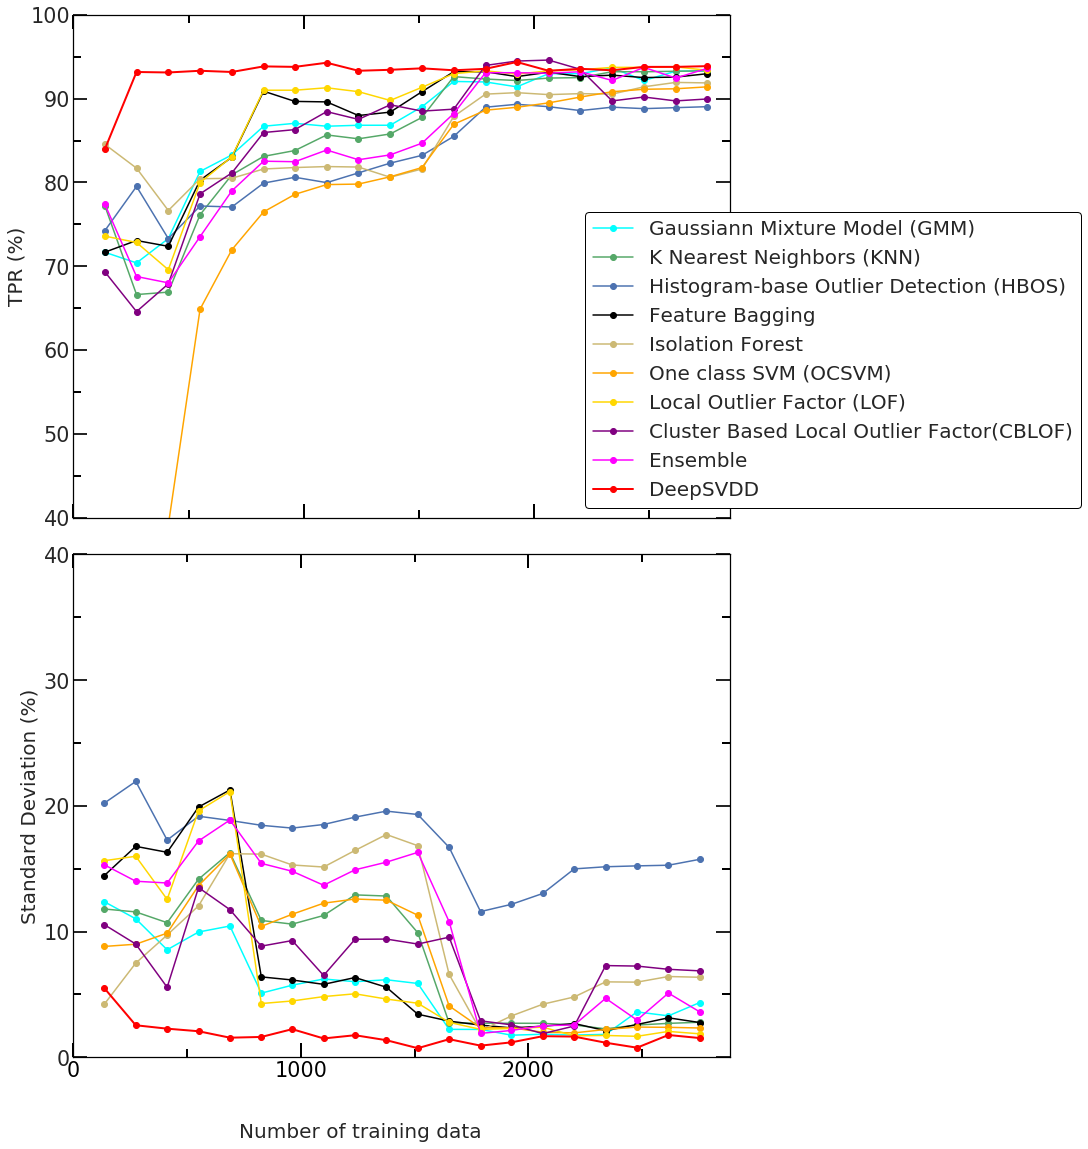

In [65]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
fig, axes = plt.subplots(figsize=(15,15),nrows=2, ncols=1,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1= axes.flatten()


ax0.plot(train_sizes,accuracy[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax0.plot(train_sizes, accuracy[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax0.plot(train_sizes, accuracy[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax0.plot(train_sizes,accuracy[3], 'o-', color="black", label= 'Feature Bagging' )
ax0.plot(train_sizes,accuracy[4], 'o-', color="y", label= 'Isolation Forest' )
ax0.plot(train_sizes, accuracy[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax0.plot(train_sizes, accuracy[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax0.plot(train_sizes, accuracy[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax0.plot(train_sizes, accuracy[8], 'o-', color="magenta", label='Ensemble') 
ax0.plot(train_sizes, accuracy[9], 'o-', color="red", label= 'DeepSVDD', linewidth=2.0)
ax0.set_ylim(40, 100)
ax0.set_xlim(130, 2850)
#ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(40, 100.1, 10)
minor_ticks_y = np.arange(40, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.set_ylabel('TPR (%)', fontsize=20)


ax1.set_ylim(0, 40)
ax1.plot(train_sizes, std[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax1.plot(train_sizes, std[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax1.plot(train_sizes, std[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax1.plot(train_sizes, std[3], 'o-', color="black", label= 'Feature Bagging' )
ax1.plot(train_sizes, std[4], 'o-', color="y", label= 'Isolation Forest' )
ax1.plot(train_sizes, std[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax1.plot(train_sizes, std[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax1.plot(train_sizes, std[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax1.plot(train_sizes, std[8], 'o-', color="magenta", label= 'Ensemble' )
ax1.plot(train_sizes, std[9], 'o-', color="red", label= 'DeepSVDD', linewidth=2.0)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(0, 40.1, 10)
minor_ticks_y = np.arange(0, 40.1, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_ylabel('Standard Deviation (%)', fontsize=20)

ax0.legend(prop={'size': 20},  loc=(0.78, 0.02), facecolor='white', framealpha=1, edgecolor='black')

fig.text(0.33, -0.05, 'Number of training data', ha='center',fontsize=20 )
#plt.savefig('/content/drive/My Drive/cocrystal_design/figures_si/learning_curves_si.png', rasterized=True,  bbox_inches="tight", dpi=600)


# k-fold cross validation comparison

In [44]:
val_list.append(ens_kfold )
val_list.append(deep_kfold)

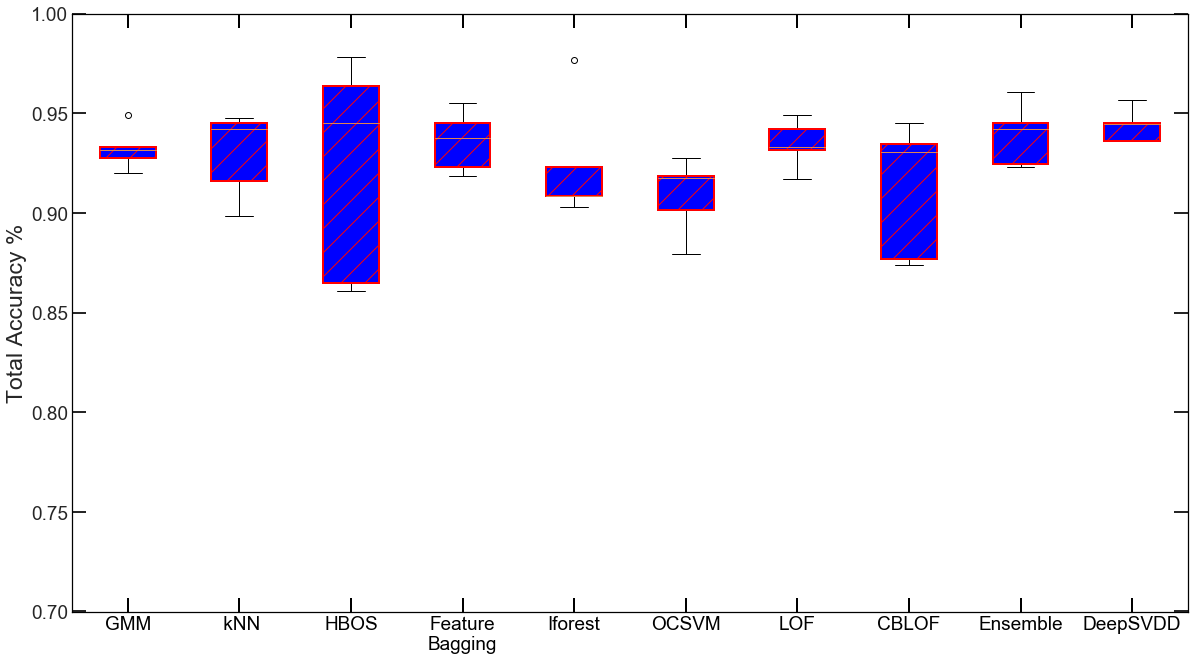

In [45]:
# Box plot with scores
#Import the accuracies table 

# Accuracy on the known data 
import seaborn as sns


data1 = val_list #[model_acc.GMM , model_acc.kNN ,model_acc.HBOS  ,model_acc.Feat_bag ,model_acc.Iforest ,model_acc.OCSVM ,model_acc.LOF ,model_acc.CBLOF ,model_acc.Ensemble ,model_acc.DeepSVDD ]

sns.set(rc={'figure.figsize':(20 ,11)})
sns.set_style("whitegrid", {'axes.grid' : False})

fig1, ax1 = plt.subplots()
ax1.set_ylim(0.7, 1)
#ax1.set_yticks([80, 90 ,100])
ax1.set_xticklabels(['GMM', ' kNN', 'HBOS', 'Feature\nBagging',   'Iforest', 'OCSVM',  'LOF', 'CBLOF', 'Ensemble', 'DeepSVDD' ])
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
#major_ticks_y = np.arange(70, 100.1, 10)
#minor_ticks_y = np.arange(70, 100.1, 5)

#ax1.set_yticks(major_ticks_y)
#ax1.set_yticks(minor_ticks_y, minor=True)
bp0=ax1.boxplot(data1, patch_artist=True)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue' )
    # change hatch
    box.set(hatch = '/')
#plt.xlabel('One class classification models',  fontsize=18)
plt.ylabel('Total Accuracy %', fontsize=23 )
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
#plt.title('AUC=%.3f,   F1-score=%.3f' % (auc, f1) ,fontsize=18)
ax1.xaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
#plt.savefig("box_plots.png", dpi=600)




# Scores distribution of the standard one class models

In [104]:
model_scores = pd.read_pickle('/content/drive/My Drive/cocrystal_design-master/data_test/model_scores.pkl') 
deep_scores = pd.read_csv('../data/deep_scores_60_epochs')
  

In [105]:
model_scores

,gmm1,knn1,hbos1,feat_bag,ifor1,ocsvm1,lof1,cblof1,ens
0,0.691575,0.557694,0.421483,0.810719,0.648074,0.117586,0.882286,0.718967,0.632528
1,0.498174,0.342286,0.341724,0.326921,0.473766,0.014637,0.456751,0.617384,0.389817
2,0.996109,0.933331,0.900662,0.979496,0.972670,0.741551,0.950110,0.890449,0.958155
3,0.694048,0.597889,0.293129,0.638090,0.374545,0.202982,0.706894,0.767950,0.545205
4,0.589416,0.500046,0.329792,0.355123,0.547832,0.046388,0.000000,0.663808,0.370496
...,...,...,...,...,...,...,...,...,...
25175,0.914761,0.665413,0.405562,0.883774,0.718976,0.261863,0.952693,0.675601,0.697408
25176,0.839661,0.638360,0.437827,0.886911,0.650134,0.196016,0.927097,0.633898,0.659936
25177,0.892569,0.629710,0.359590,0.806775,0.698474,0.233015,0.840982,0.651057,0.643230
25178,0.809651,0.634258,0.391855,0.777447,0.657829,0.260670,0.795317,0.680684,0.639219


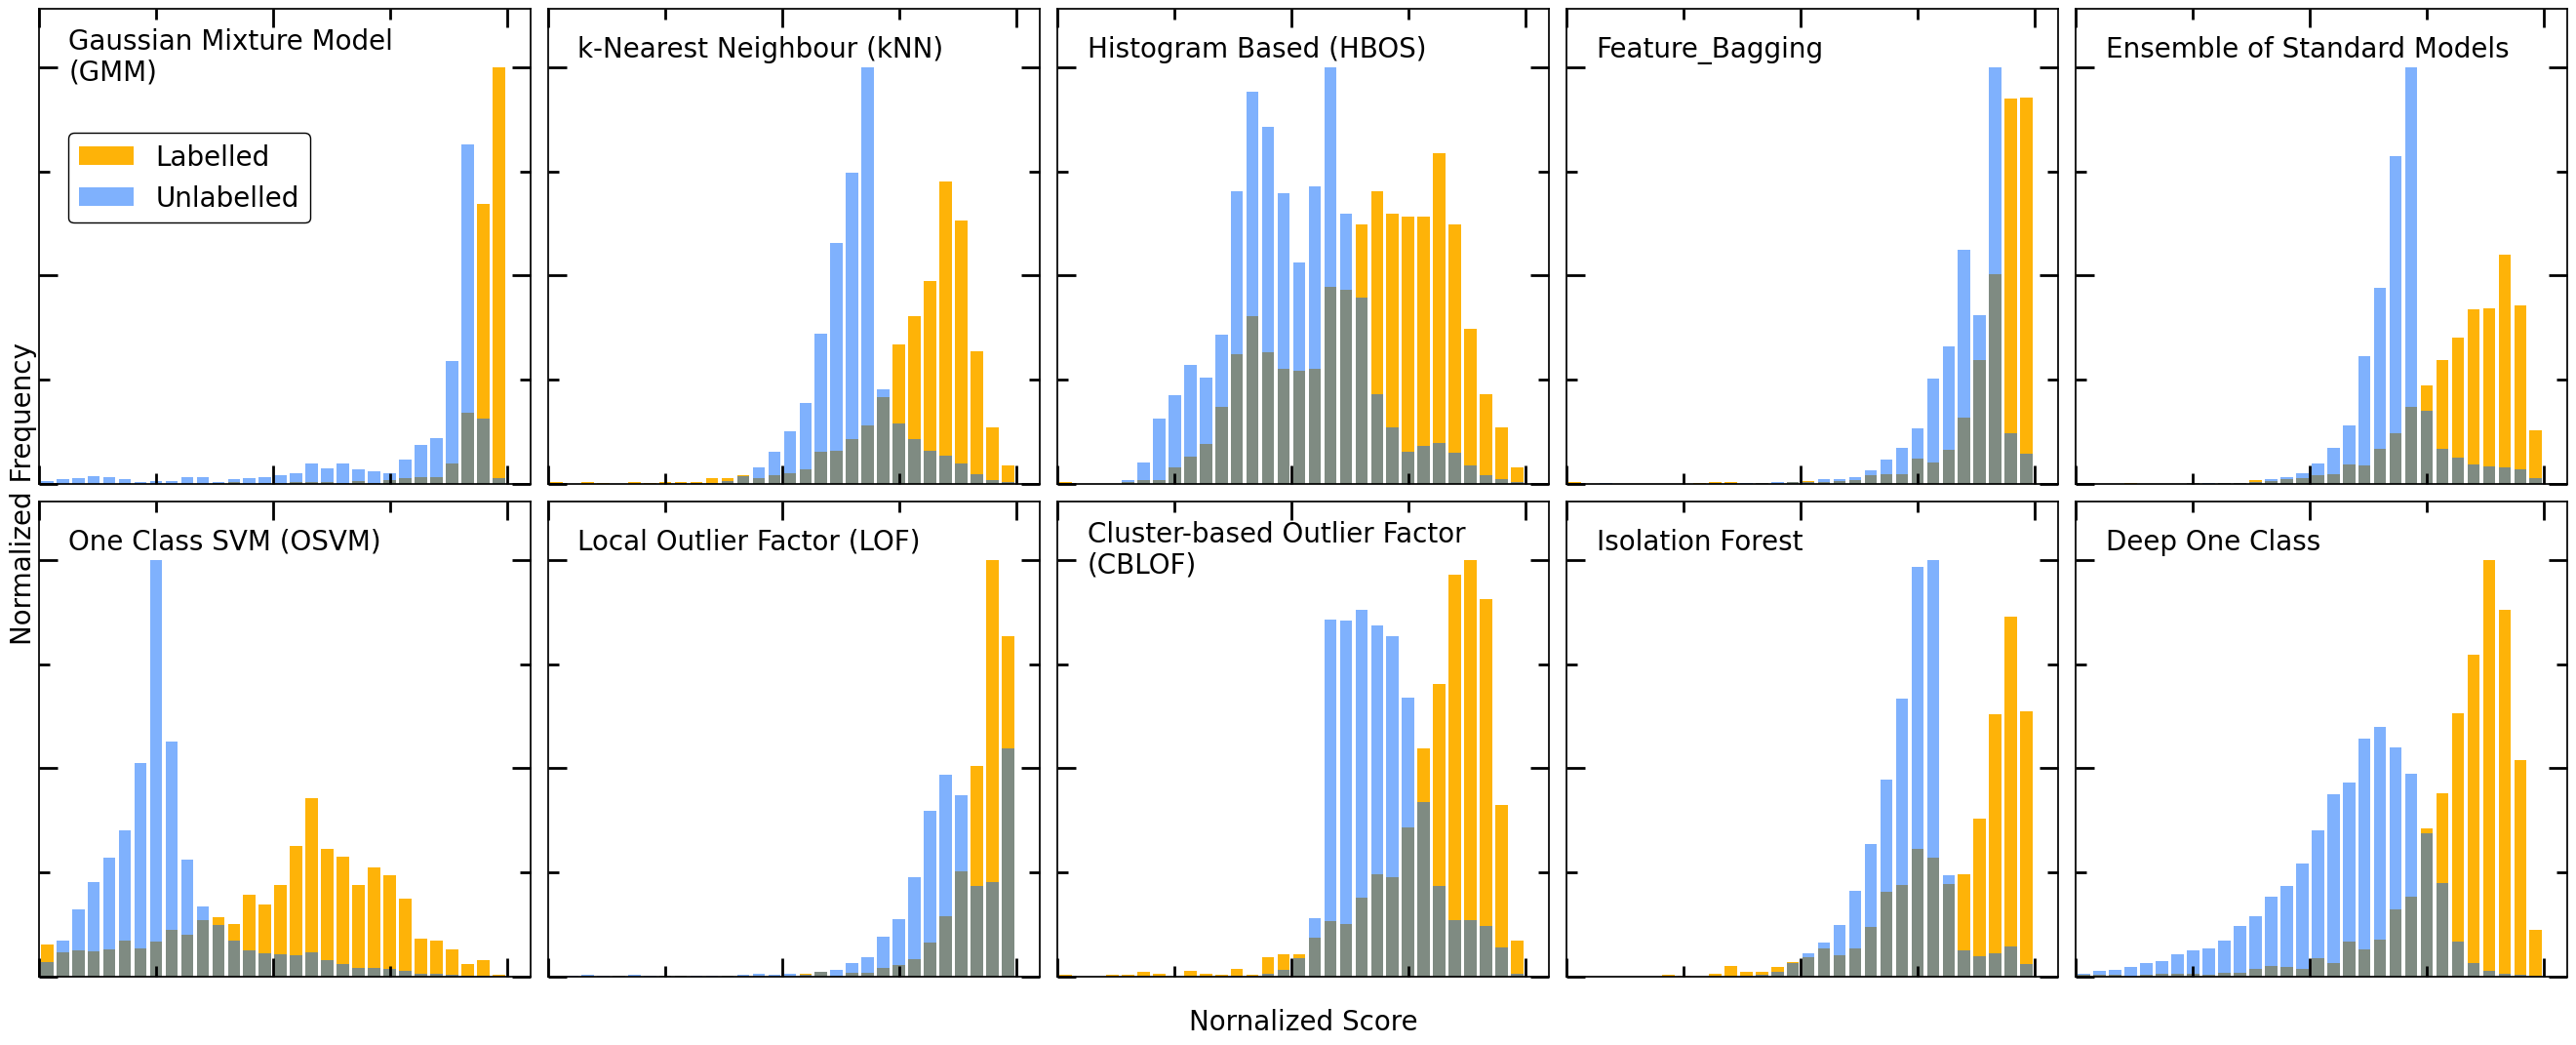

In [119]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(26, 10), nrows=2, ncols=5,
                         constrained_layout=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"] = "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"


major_ticks_x = np.arange(0, 1.1, 0.5)
minor_ticks_x = np.arange(0, 1.1, 0.25)
major_ticks_y = np.arange(0, 1.1, 0.5)
minor_ticks_y = np.arange(0, 1.1, 0.25)

n_bins = 30


def set_ticks(ax):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    #ax.tick_params(axis='both', top='off', bottom='off', left='off', right='off')
    #ax.xaxis.set_ticks_position('none') 
    #ax.yaxis.set_ticks_position('none') 
    #ax.set_xticks([], minor=True)
    #ax.set_yticks([], minor=True)


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')


def set_prop(ax):
    ax.axis(aspect='equal')
    ax.set(adjustable='box')  # , aspect='equal')
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.14)
    ax.grid(False)
    set_spines(ax)
    ax.set_facecolor('xkcd:white')
    ax.axis('on')
    #set_ticks(ax)

def norm_plot(ax, x, y, alpha=1, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    hist1, _ = np.histogram(y, **kwargs)
    n_max = np.max([hist, hist1])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist / n_max, align='center', width = width, alpha=alpha)
    return hist, n_max


def lab_unlab_plot(ax, lab_d, unlab_d, n_bins):
    hist_lab, bins_lab = np.histogram(lab_d, bins=n_bins, density=True, range=(0,1))
    hist_unlab, bins_unlab = np.histogram(unlab_d, bins=n_bins, density=True, range=(0,1))
    n_max = np.max([hist_lab, hist_unlab])
    width_lab = 0.8 * (bins_lab[1] - bins_lab[0])
    width_unlab = 0.8 * (bins_unlab[1] - bins_unlab[0])
    center_lab = (bins_lab[:-1] + bins_lab[1:]) / 2
    center_unlab = (bins_unlab[:-1] + bins_unlab[1:]) / 2
    ax.bar(center_lab, hist_lab / n_max, align='center', width=width_lab, alpha=1, color='#feb308', label = 'Labelled')
    ax.bar(center_unlab, hist_unlab / n_max, align='center', width=width_unlab, alpha=0.5, color='#0165fc', label = 'Unlabelled')



# Gaussian Mixture Model
lab_unlab_plot(ax0, model_scores.gmm1[:3444], model_scores.gmm1[3444:], n_bins)
# ax0.axis(aspect='equal')
ax0.text(0.06, 0.85, 'Gaussian Mixture Model\n(GMM)',
         transform=ax0.transAxes, ha="left", fontsize=20)
#ax0.legend(prop={'size': 20}, loc=(0.02, 0.65), facecolor='white', framealpha=0)
ax0.legend(prop={'size': 20}, loc=(0.06, 0.55), facecolor='white', edgecolor='black', framealpha=1)#,  borderpad=1 ) #shadow=True, fancybox=True, loc=(0.75, -0.15),
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# knn
n_bins = 30
lab_unlab_plot(ax1, model_scores.knn1[:1722], model_scores.knn1[1722:], n_bins)
ax1.text(0.06, 0.9, 'k-Nearest Neighbour (kNN)',
         transform=ax1.transAxes, ha="left", fontsize=20)
#ax1.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# HBOS
lab_unlab_plot(ax2, model_scores.hbos1[:1722], model_scores.hbos1[1722:], n_bins)
ax2.text(0.06, 0.9, 'Histogram Based (HBOS)',
         transform=ax2.transAxes, ha="left", fontsize=20)
#ax2.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Feature Bagging
lab_unlab_plot(ax3, model_scores.feat_bag[:1722], model_scores.feat_bag[1722:], n_bins)
ax3.text(0.06, 0.9, 'Feature_Bagging',
         transform=ax3.transAxes, ha="left", fontsize=20)
#ax3.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Isolation Forest
lab_unlab_plot(ax8, model_scores.ifor1[:1722], model_scores.ifor1[1722:], n_bins)
ax8.text(0.06, 0.9, 'Isolation Forest',
         transform=ax8.transAxes, ha="left", fontsize=20)
#ax8.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax8.set_xticklabels([])
ax8.set_yticklabels([])

# OCSVM
lab_unlab_plot(ax5, model_scores.ocsvm1[:1722], model_scores.ocsvm1[1722:], n_bins)
ax5.text(0.06, 0.9, 'One Class SVM (OSVM)',
         transform=ax5.transAxes, ha="left", fontsize=20)
#ax5.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax5.set_xticklabels([])
ax5.set_yticklabels([])

# LOF
lab_unlab_plot(ax6, model_scores.lof1[:1722], model_scores.lof1[1722:], n_bins)
ax6.text(0.06, 0.9, 'Local Outlier Factor (LOF)',
         transform=ax6.transAxes, ha="left", fontsize=20)
#ax6.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
ax6.set_xticklabels([])
ax6.set_yticklabels([])


# CBLOF
lab_unlab_plot(ax7, model_scores.cblof1[:1722], model_scores.cblof1[1722:], n_bins)
ax7.text(0.06, 0.85, 'Cluster-based Outlier Factor\n(CBLOF)',
         transform=ax7.transAxes, ha="left", fontsize=20)
#ax7.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
ax7.set_xticklabels([])
ax7.set_yticklabels([])

# DeepSVDD
lab_unlab_plot(ax9, deep_scores.score[:1722], deep_scores.score[1722:], n_bins)
ax9.text(0.06, 0.9, 'Deep One Class',
         transform=ax9.transAxes, ha="left", fontsize=20)
#ax9.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax9.set_xticklabels([])
ax9.set_yticklabels([])

# Ensemble
lab_unlab_plot(ax4, model_scores.ens[:1722], model_scores.ens[1722:], n_bins)
ax4.text(0.06, 0.9, 'Ensemble of Standard Models', 
        transform=ax4.transAxes, ha="left", fontsize=20)
#ax4.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for ax in axes.flatten():
  set_prop(ax)
  set_ticks(ax)

fig.tight_layout()


fig.text(0.5, -0.05, 'Nornalized Score', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', fontsize=20)
plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure2_new.svg', rasterized=True,  bbox_inches="tight", dpi=600)

plt.show()


# Scores correlation between deep one class and the ensemble

In [113]:
ense = pd.read_pickle('/content/drive/My Drive/cocrystal_design-master/data_test/ensemble_score.pkl')      
ens = ense.iloc[:, 0].values

In [114]:
deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/deep_scores_100-100_fin1.csv')


In [117]:
from scipy import stats
deep=deep_scores.score.values
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.705]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
tzaki = pd.concat([pd.DataFrame(data.deep.values, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

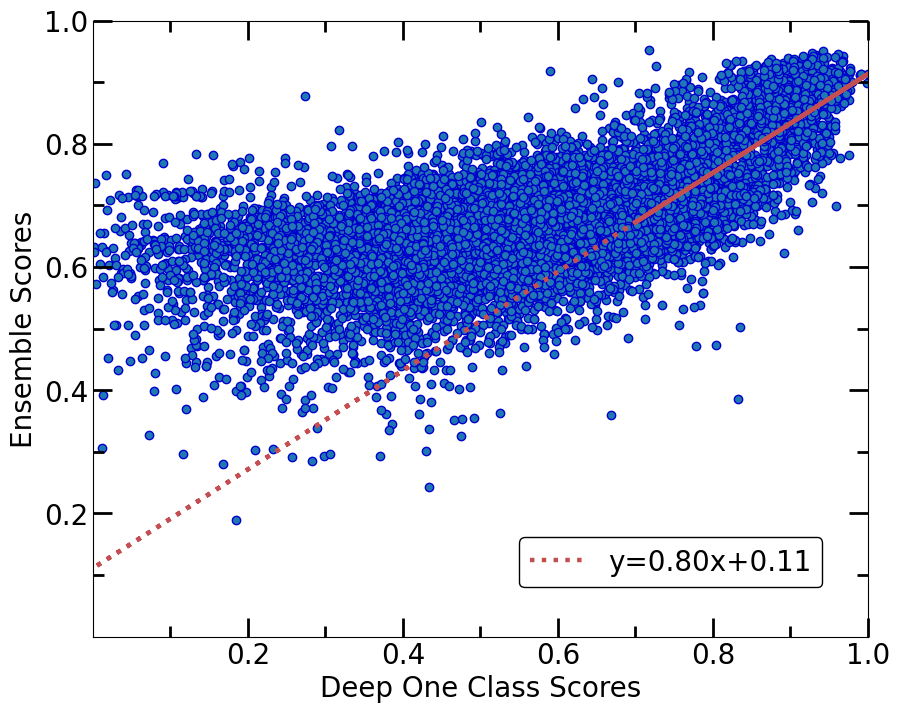

In [118]:
from matplotlib import rc
import seaborn as sns
import matplotlib.font_manager
#plt.rcParams["font.weight"] = "light"
#plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['axes.facecolor'] = 'white'


plt.style.use('default')
import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "normal"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False

#fig = plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
rcParams["axes.edgecolor"] = "0.15"
rcParams["axes.linewidth"]  = 1.25

plt.scatter(data.deep, data.ens, edgecolors='#0000CC')
slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept
#plt.plot(deep, line, 'r', linewidth=3.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(loc='lower right')

plt.grid(False)

plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Ensemble Scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
# this is an inset axes over the main axes
#a = plt.axes([.6, .15, .28, .28], facecolor='white')
#sns.regplot(x="deep", y="ens", data=data1, color='b',
 #line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

#plt.scatter(data1.deep, data1.ens, edgecolors='#0000CC')
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
#plt.plot(data.deep, line,  'r', linestyle='-', linewidth=3.0, dashes=(5, 2), label='y1={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot(tzaki[tzaki.deep > 0.7].deep,tzaki[tzaki.deep > 0.7].line, 'r-',  linewidth=3.2)
plt.plot(tzaki[tzaki.deep < 0.7].deep,tzaki[tzaki.deep < 0.7].line, 'r:',  linewidth=3.2, label='y={:.2f}x+{:.2f}'.format(slope,intercept))


slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept

#plt.plot(deep, line, 'r', linewidth=3.0, label='y1={:.2f}x+{:.2f}'.format(slope,intercept))

major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0, 1.001, 0.1)
major_ticks_y = np.arange(0, 1.001, 0.2)
minor_ticks_y = np.arange(0, 1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
#plt.title('Probability')
#plt.xticks([])
#plt.yticks([])
plt.legend(prop={'size': 20}, loc=(0.55, 0.08), facecolor='white', edgecolor='black', framealpha=1 )
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/scatter1_0.7.png', dpi=600)